In [73]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.layers import Dense,Dropout,Input,LeakyReLU
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

In [74]:
#Load data
(Xtrain,Ytrain),(Xtest,Ytest)=mnist.load_data()

In [75]:
print("range: ",(Xtest.min(),Xtest.max()))

range:  (0, 255)


In [76]:
#Changing the data scale in the range of (-1,1)
scaler = lambda a: (a.astype(np.float32)-127.5)/127.5
Xtrain,Xtest=scaler(Xtrain),scaler(Xtest)

In [77]:
print("range: ",(Xtest.min(),Xtest.max()))

range:  (-1.0, 1.0)


In [78]:
#Shape of the data
print(Xtrain.shape,"\n",Xtest.shape)
#The shape of the data must be vector.
Xtrain=Xtrain.reshape((60000,28*28))
Xtest=Xtest.reshape((10000,28*28))

Xtrain.shape

(60000, 28, 28) 
 (10000, 28, 28)


(60000, 784)

In [79]:
#Create the Generator
def generator_model():
    generator = tf.keras.models.Sequential()

    #Dense layer with LeakyReLU activation function
    #Our noise random vector is 100 size (this value is optional)
    generator.add(Dense(256,input_dim=100))
    generator.add(LeakyReLU(0.2))

    #Dense layer with LeakyReLU activation function
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    #Dense layer with LeakyReLU activation function
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    #Output layer with tanh activation function
    #28*28 = 784--> output size
    generator.add(Dense(784,activation="tanh"))

    #Compile the model
    generator.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0002,beta_1=0.5)
    )
    return generator

In [80]:
generator = generator_model()
generator.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_54 (Dense)            (None, 1024)              525312    
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_55 (Dense)            (None, 784)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [81]:
#Create the Discriminator
def discriminator_model():
    disc=tf.keras.models.Sequential()

    #Dense layer with LeakyReLU activation function
    disc.add(Dense(1024,input_dim=784))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.3))

    #Dense layer with LeakyReLU activation function
    disc.add(Dense(512))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.3))

    #Dense layer with LeakyReLU activation function
    disc.add(Dense(256))
    disc.add(LeakyReLU(0.2))

    #Output layer
    disc.add(Dense(1,activation="sigmoid"))

    #Compile the model
    disc.compile(
        loss="binary_crossentropy",
        optimizer=Adam(lr=0.0002,beta_1=0.5)
    )
    return disc

In [82]:
disc = discriminator_model()
disc.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_57 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_58 (Dense)            (None, 256)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [83]:
#Create the GAN model
def GAN(generator,discriminator):
    """We should have trained the Disciminator before,\n
     and now it should not be trained anymore.\n
     The generator is being trained in our gan network"""

    discriminator.trainable=False
    gan_input=Input(shape=(100,))
    x=generator(gan_input)
    gan_output=discriminator(x)
    gan = tf.keras.models.Model(
        inputs=gan_input,outputs=gan_output
        )
    gan.compile(
        loss="binary_crossentropy",
        optimizer="adam"
    )
    return gan

In [84]:
gan=GAN(generator,disc)
gan.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_14 (Sequential)  (None, 784)               1486352   
                                                                 
 sequential_15 (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [89]:
#Create image plotter
def plot_generated_images(epoch,generator,
                          examples=100,dim=(20,20),figsize=(10,10)):
    noise=np.random.normal(loc=0,scale=1,size=[examples,100])
    generated_images=generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.tight_layout()
    plt.savefig("GAN_generated_images %d.png" %epoch)


In [90]:
def train(epochs=1,batch_size=128):
    #data:Xtrain,Ytrain,Xtest,Ytest

    batch_count=Xtrain.shape[0]/batch_size

    #Create GAN
    generator = generator_model()
    discriminator = discriminator_model()
    gan = GAN(generator,discriminator)

    for e in range(1,epochs+1):
        print("Epoch %d"%e)
        for _ in tqdm(range(batch_size)):
            #generate random noise as an input to initialize the generator
            noise = np.random.normal(0,1,[batch_size,100])
            #generate fake mnist images from noised input
            generated_images=generator.predict(noise)
            #get a random set of real images
            image_batch=Xtrain[np.random.randint(
                low=0,high=Xtrain.shape[0],size=batch_size
            )]
            #construct different batches of real and fake data
            X=np.concatenate([image_batch,generated_images])
            #labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9

            #pre train discriminator on fake and real data befor starting GAN
            discriminator.trainable=True
            discriminator.train_on_batch(X,y_dis)

            #tricking the noised input of the Generator as real data
            noise=np.random.normal(0,1,[batch_size,100])
            y_gen = np.ones(batch_size) #We expect our GAN to predict 1

            #during the training of gan,
            #the weights of discriminator should be fixed.
            #we can enforce that by setting the trainable flag.
            discriminator.tranable=False

            #training the GAN by altenating the training of the discriminator
            #and training the chained GAN model with discriminator's weights freezed.
            gan.train_on_batch(noise,y_gen)
        
        if e == 1 or e % 20 == 0:
            plot_generated_images(e,generator)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1


100%|██████████| 128/128 [00:09<00:00, 14.11it/s]


Epoch 2


100%|██████████| 128/128 [00:08<00:00, 15.65it/s]


Epoch 3


100%|██████████| 128/128 [00:08<00:00, 15.46it/s]


Epoch 4


100%|██████████| 128/128 [00:08<00:00, 14.26it/s]


Epoch 5


100%|██████████| 128/128 [00:08<00:00, 15.81it/s]


Epoch 6


100%|██████████| 128/128 [00:08<00:00, 15.52it/s]


Epoch 7


100%|██████████| 128/128 [00:08<00:00, 15.49it/s]


Epoch 8


100%|██████████| 128/128 [00:08<00:00, 15.76it/s]


Epoch 9


100%|██████████| 128/128 [00:08<00:00, 15.41it/s]


Epoch 10


100%|██████████| 128/128 [00:08<00:00, 15.49it/s]


Epoch 11


100%|██████████| 128/128 [00:08<00:00, 15.31it/s]


Epoch 12


100%|██████████| 128/128 [00:08<00:00, 15.49it/s]


Epoch 13


100%|██████████| 128/128 [00:08<00:00, 15.88it/s]


Epoch 14


100%|██████████| 128/128 [00:08<00:00, 15.94it/s]


Epoch 15


100%|██████████| 128/128 [00:08<00:00, 14.94it/s]


Epoch 16


100%|██████████| 128/128 [00:08<00:00, 14.62it/s]


Epoch 17


100%|██████████| 128/128 [00:08<00:00, 15.81it/s]


Epoch 18


100%|██████████| 128/128 [00:08<00:00, 15.65it/s]


Epoch 19


100%|██████████| 128/128 [00:08<00:00, 15.81it/s]


Epoch 20


100%|██████████| 128/128 [00:08<00:00, 15.78it/s]


Epoch 21


100%|██████████| 128/128 [00:08<00:00, 15.48it/s]


Epoch 22


100%|██████████| 128/128 [00:08<00:00, 15.61it/s]


Epoch 23


100%|██████████| 128/128 [00:08<00:00, 15.77it/s]


Epoch 24


100%|██████████| 128/128 [00:08<00:00, 15.81it/s]


Epoch 25


100%|██████████| 128/128 [00:08<00:00, 15.74it/s]


Epoch 26


100%|██████████| 128/128 [00:08<00:00, 15.68it/s]


Epoch 27


100%|██████████| 128/128 [00:09<00:00, 13.99it/s]


Epoch 28


100%|██████████| 128/128 [00:08<00:00, 15.83it/s]


Epoch 29


100%|██████████| 128/128 [00:08<00:00, 15.70it/s]


Epoch 30


100%|██████████| 128/128 [00:08<00:00, 15.44it/s]


Epoch 31


100%|██████████| 128/128 [00:08<00:00, 15.66it/s]


Epoch 32


100%|██████████| 128/128 [00:08<00:00, 15.70it/s]


Epoch 33


100%|██████████| 128/128 [00:08<00:00, 15.67it/s]


Epoch 34


100%|██████████| 128/128 [00:08<00:00, 15.58it/s]


Epoch 35


100%|██████████| 128/128 [00:08<00:00, 15.76it/s]


Epoch 36


100%|██████████| 128/128 [00:08<00:00, 15.85it/s]


Epoch 37


100%|██████████| 128/128 [00:08<00:00, 15.93it/s]


Epoch 38


100%|██████████| 128/128 [00:08<00:00, 15.71it/s]


Epoch 39


100%|██████████| 128/128 [00:08<00:00, 14.82it/s]


Epoch 40


100%|██████████| 128/128 [00:07<00:00, 16.03it/s]


Epoch 41


100%|██████████| 128/128 [00:07<00:00, 16.07it/s]


Epoch 42


100%|██████████| 128/128 [00:08<00:00, 15.75it/s]


Epoch 43


100%|██████████| 128/128 [00:08<00:00, 15.84it/s]


Epoch 44


100%|██████████| 128/128 [00:08<00:00, 15.00it/s]


Epoch 45


100%|██████████| 128/128 [00:08<00:00, 15.35it/s]


Epoch 46


100%|██████████| 128/128 [00:08<00:00, 15.55it/s]


Epoch 47


100%|██████████| 128/128 [00:08<00:00, 15.36it/s]


Epoch 48


100%|██████████| 128/128 [00:08<00:00, 15.43it/s]


Epoch 49


100%|██████████| 128/128 [00:08<00:00, 15.39it/s]


Epoch 50


100%|██████████| 128/128 [00:08<00:00, 14.87it/s]


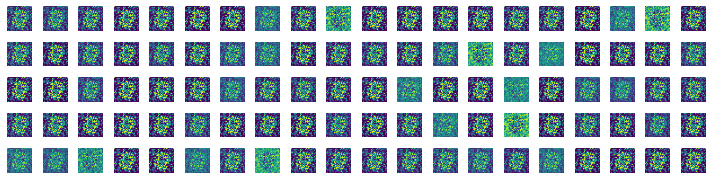

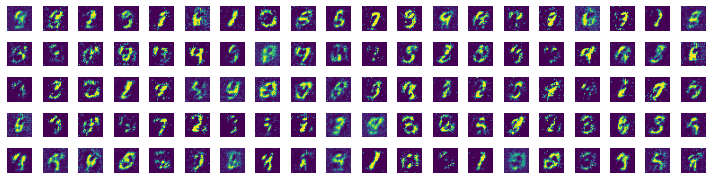

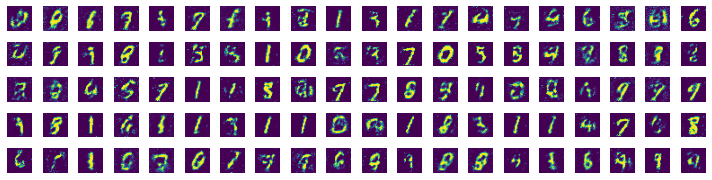

In [91]:
#Train model
train(50)